In [118]:
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import torch, re
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from collections import Counter
import time

torch.manual_seed(1)

In [204]:
conn = sqlite3.connect("scraped_data.db")

df = pd.read_sql_query("SELECT * FROM reviews", conn)
#sample_df = df.sample(n=6500, random_state=42)  # random_state for reproducibility

# Drop all rows with at least one NaN
df_clean = df.dropna(subset=['Score', 'Review_Text'])
#Test on only few data examples
#df_clean = df.sample(n=1000, random_state=42)  # random_state for reproducibility

#X = df_clean['Tokenized_Long_Text']
X = df_clean['Review_Text']
Y = df_clean['Score']
pd.set_option('display.max_colwidth', None)


In [206]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [207]:
#Tokenize data 
def simple_tokenise(text):
    return re.findall(r"[A-Za-z0-9']+", text.lower())

tokenised_train = [simple_tokenise(t) for t in X_train]
tokenised_val   = [simple_tokenise(t) for t in X_val]
tokenised_test  = [simple_tokenise(t) for t in X_test]

tokenised = tokenised_test + tokenised_val + tokenised_train

counter = Counter(w for sent in tokenised for w in sent)
specials = ["<pad>", "<unk>"]
stoi = {w:i+len(specials) for i,(w,_) in enumerate(counter.most_common())}
stoi.update({sp:i for i,sp in enumerate(specials)}) 
unk, pad = stoi["<unk>"], stoi["<pad>"]

In [208]:
max_len = 100
max_len = int(max(len(s) for s in tokenised))
print(max_len)

def encode(sent):
    ids = [stoi.get(w, unk) for w in sent][:max_len]
    return torch.tensor(ids + [pad]*(max_len-len(ids)), dtype=torch.long)

encoded_train = torch.stack([encode(s) for s in tokenised_train])
encoded_val   = torch.stack([encode(s) for s in tokenised_val])
encoded_test  = torch.stack([encode(s) for s in tokenised_test])

69


In [209]:
y_train = torch.tensor(y_train.values - 1, dtype=torch.long)  
y_val = torch.tensor(y_val.values - 1, dtype=torch.long)
y_test = torch.tensor(y_test.values - 1, dtype=torch.long)

In [219]:
# könnte vergrößert werden
batch_size = 512
train_loader = DataLoader(
    TensorDataset(encoded_train, y_train), shuffle=True, batch_size=batch_size
)
val_loader = DataLoader(
    TensorDataset(encoded_val, y_val), shuffle=False, batch_size=batch_size
)
test_loader = DataLoader(
    TensorDataset(encoded_test, y_test), shuffle=False, batch_size=batch_size
)

In [220]:
class ReviewLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, lstm_units=128, num_classes=10):
        super().__init__()display_labels = sorted(set(gts)) 
        self.emb  = nn.Embedding(vocab_size, embed_dim, padding_idx=pad)
        self.lstm = nn.LSTM(embed_dim, lstm_units, batch_first=True, bidirectional=True)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc   = nn.Linear(lstm_units*2, num_classes)    # I also tried with regression, didn't get better results

    def forward(self, x):
        x = self.emb(x)                        
        x, _ = self.lstm(x)                    
        x = self.pool(x.transpose(1,2)).squeeze(-1)  
        return self.fc(x)                    

model = ReviewLSTM(len(stoi))

In [221]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

Using cuda


In [222]:
 torch.cuda.empty_cache()

In [223]:
model = ReviewLSTM(vocab_size=len(stoi)).to(device)
criterion = nn.CrossEntropyLoss()
# 1.5e-1
optimiser = torch.optim.Adam(model.parameters(), lr=1e-1)

patience = 10
best_val_acc = 0
epochs_no_improve = 0
num_epochs = 100

In [224]:
for epoch in range(1, num_epochs + 1):
    t0 = time.time()
    # ---- train ----
    model.train()
    train_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimiser.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimiser.step()
        train_loss += loss.item() * Xb.size(0)

    # ---- validate ----
    model.eval()
    val_loss, preds, gts = 0, [], []
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            logits = model(Xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * Xb.size(0)
            preds.extend(logits.argmax(1).cpu().tolist())
            gts.extend(yb.cpu().tolist())

    train_loss /= len(train_loader.dataset)
    val_loss   /= len(val_loader.dataset)
    val_acc     = accuracy_score(gts, preds)

    print(f"Epoch {epoch:2d} | "
          f"train loss {train_loss:.4f} | "
          f"val loss {val_loss:.4f} | "
          f"val acc {val_acc*100:5.2f}% | "
          f"time {time.time()-t0:.1f}s")


    # ---- early stopping ----
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_review_lstm.pth")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

Epoch  1 | train loss 4.1380 | val loss 2.4316 | val acc 17.69% | time 1.3s
Epoch  2 | train loss 2.0313 | val loss 2.0496 | val acc 21.30% | time 1.2s
Epoch  3 | train loss 1.6516 | val loss 2.1351 | val acc 22.92% | time 1.2s
Epoch  4 | train loss 1.4415 | val loss 2.1931 | val acc 23.29% | time 1.3s
Epoch  5 | train loss 1.2929 | val loss 2.2939 | val acc 23.65% | time 1.2s
Epoch  6 | train loss 1.2048 | val loss 2.3891 | val acc 22.38% | time 1.2s
Epoch  7 | train loss 1.1529 | val loss 2.5298 | val acc 20.76% | time 1.2s
Epoch  8 | train loss 1.1091 | val loss 2.6611 | val acc 21.30% | time 1.2s
Epoch  9 | train loss 1.0846 | val loss 2.7528 | val acc 21.84% | time 1.3s
Epoch 10 | train loss 1.0715 | val loss 2.7708 | val acc 22.20% | time 1.2s
Epoch 11 | train loss 1.0512 | val loss 2.8985 | val acc 21.30% | time 1.2s
Epoch 12 | train loss 1.0459 | val loss 2.9126 | val acc 22.38% | time 1.2s
Epoch 13 | train loss 1.0545 | val loss 2.9955 | val acc 22.56% | time 1.2s
Epoch 14 | t


Test accuracy: 28.72%


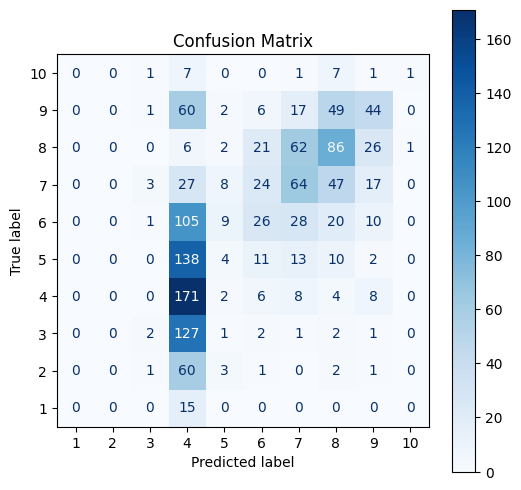

In [225]:
# Vizualization
model.eval()
preds, gts = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        preds.extend(logits.argmax(1).cpu().tolist())
        gts.extend(yb.tolist())
        
test_acc = accuracy_score(gts, preds)
print(f"\nTest accuracy: {test_acc*100:.2f}%")

cm = confusion_matrix(gts, preds)
fig, ax = plt.subplots(figsize=(6, 6))
display_labels = [label + 1 for label in sorted(set(gts))]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')  # 'd' = integer format
plt.title("Confusion Matrix")
ax.invert_yaxis()
plt.grid(False)
plt.show()